In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#____________________________________________________________

import glob
import pathlib
import tensorflow as tf
import cv2, os, random
from termcolor import colored
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)


#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()

path_for_data = pathlib.Path(current_dir) / 'data' / 'dataset' / 'crop'

print('If correct, Active Directory should read: /Users/delimey/Documents/VisualStudio/aircraft-id')
print(f"Active Directory: {current_dir}")
print(f'Image source is set to {path_for_data}')

If correct, Active Directory should read: /Users/delimey/Documents/VisualStudio/aircraft-id
Active Directory: /Users/delimey/Documents/VisualStudio/aircraft-id
Image source is set to /Users/delimey/Documents/VisualStudio/aircraft-id/data/dataset/crop


In [3]:
train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.3,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 25,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_data,
                                             image_size = (128, 128),
                                             validation_split = 0.35,
                                             subset = "validation",
                                             shuffle = True,                                         
                                             batch_size = 25,
                                             seed = 123)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 21739 files belonging to 46 classes.
Using 15218 files for training.
Found 21739 files belonging to 46 classes.
Using 7608 files for validation.
The datasets were succesfully loaded...


In [4]:
train_df, validation_df

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [5]:
print("There are {} images in the training dataset".format(len(train_df)))
print("There are {} images in the validation dataset".format(len(validation_df)))

There are 609 images in the training dataset
There are 305 images in the validation dataset


In [6]:
validation_batches = tf.data.experimental.cardinality(validation_df)
validation_batches

<tf.Tensor: shape=(), dtype=int64, numpy=305>

In [7]:
# take validation batches for test set
test_df = validation_df.take(validation_batches // 5)

# skip validation batches for validation set
validation_df = validation_df.skip(validation_batches // 5)

test_df, validation_df

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

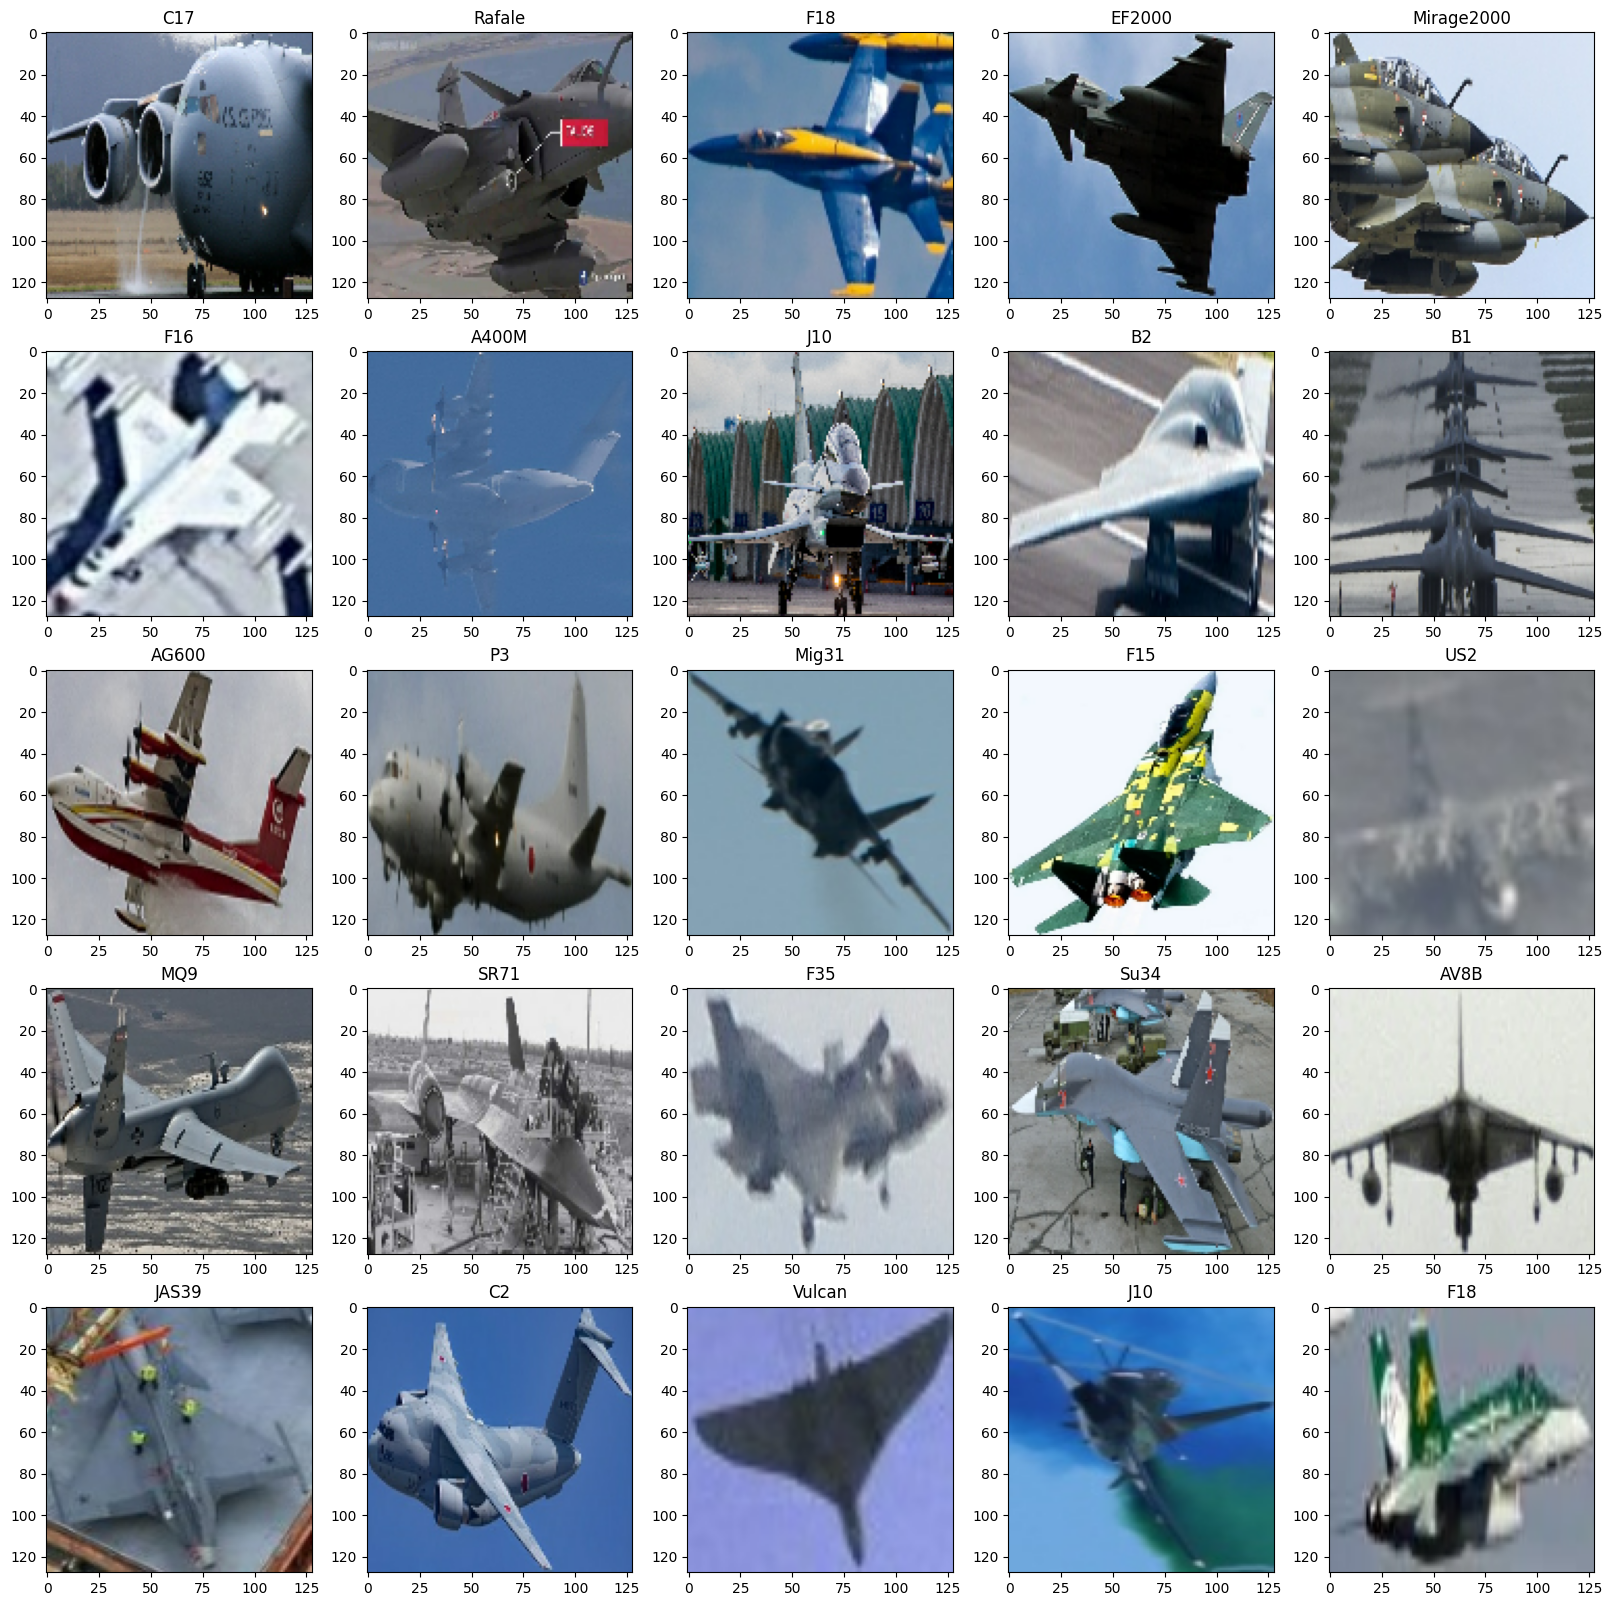

In [8]:
class_names = train_df.class_names

plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [9]:
autotune = tf.data.AUTOTUNE
pf_train = train_df.prefetch(buffer_size = autotune)
pf_test = test_df.prefetch(buffer_size = autotune)
pf_val = validation_df.prefetch(buffer_size = autotune)

In [10]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))

In [11]:
# basic setup
image_size = (128, 128)
image_shape = image_size + (3,)

In [12]:
# input processing
preprocess_input = applications.resnet50.preprocess_input

In [13]:
# base model (ResNet50)
base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')

In [14]:
# freeze layers
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [15]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

In [16]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [17]:
image_file = '/kaggle/working/model_plot.png'
plot_model(model, to_file = image_file, show_shapes = True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [19]:
optimizer = optimizers.legacy.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [20]:
history = model.fit(pf_train, validation_data = (pf_val), epochs = 1)

609/609 [==============================] - 179s 291ms/step - loss: 2.7350 - accuracy: 0.3238 - val_loss: 2.2623 - val_accuracy: 0.3965


In [21]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [23]:
optimizer = optimizers.legacy.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [25]:
ft_epoch = 3
n_epochs =+ ft_epoch

history_fine = model.fit(pf_train, validation_data = (pf_val), epochs = n_epochs, initial_epoch = history.epoch[-1])

Epoch 1/3
609/609 [==============================] - 353s 578ms/step - loss: 0.6582 - accuracy: 0.8355 - val_loss: 1.0184 - val_accuracy: 0.7062
Epoch 2/3
609/609 [==============================] - 972s 2s/step - loss: 0.6531 - accuracy: 0.8353 - val_loss: 1.0208 - val_accuracy: 0.7067
Epoch 3/3
609/609 [==============================] - 352s 578ms/step - loss: 0.6501 - accuracy: 0.8381 - val_loss: 1.0153 - val_accuracy: 0.7080


In [26]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)


1/1 [==============================] - 1s 599ms/step


In [27]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

[[20 20]
 [18 45]
 [10 10]
 [ 4  4]
 [ 0  0]
 [ 2  2]
 [25  3]
 [37 22]
 [19 19]
 [14 17]
 [32 18]
 [ 6 17]
 [19 18]
 [18 18]
 [41 41]
 [22 14]
 [ 9  9]
 [ 0  0]
 [18 18]
 [18 18]
 [21 21]
 [17 17]
 [21 21]
 [36 27]
 [ 8  6]]
